In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from include.remote_calls import get_binance_price_coingecko

In [2]:
def intersection(resell_list, sell_list):
    """
    All elements found in resell and not found in sell, thus, active sales.
    """
    lst3 = [value for value in resell_list if value not in sell_list]
    return lst3

In [3]:
trx_df = pd.read_csv("db/transactions/transactions_hist.csv", parse_dates=['date'])

In [4]:
# Check active sales
trx_resell_df = trx_df[trx_df['tr_type'] == 'resell']
trx_resell = trx_resell_df['ship_id'].unique()

trx_sell_df = trx_df[trx_df['tr_type'] == 'sell']
trx_sell = trx_sell_df['ship_id'].unique()

trx_active = intersection(trx_resell, trx_sell)


In [5]:
# Total profit
hist_df = trx_df[~trx_df['ship_id'].isin(trx_active)]
buy_df = hist_df[hist_df['tr_type'] == 'buy']
sell_df = hist_df[hist_df['tr_type'] == 'sell']
bnb_price = get_binance_price_coingecko()

profit_bnb = round(sell_df['price'].sum() - buy_df['price'].sum(), 2)
profit_usd = round((sell_df['price'].sum() - buy_df['price'].sum()) * bnb_price,2)

print(f"Total profit BNB: {profit_bnb}")
print(f"Total profit USD: {profit_usd}")

Total profit BNB: 0.23
Total profit USD: 116.59


In [6]:
# Period of time
hist_df['date'].max() - hist_df['date'].min()

Timedelta('103 days 00:00:00')

In [7]:
# [WIP] Active sales. [!!! Get ship stats online not offline]
sold_ships_df = pd.read_csv("db/extracted_sold_BNB_old.csv", header=None)
sold_ships_df.drop_duplicates(subset=[1], keep='last', inplace=True)

ships_active_df = sold_ships_df[sold_ships_df[1].isin(trx_active)][[1,5,6,7,8,9,10]]
ships_active_df.reset_index(drop=True, inplace=True)
columns = ['ship_id','space', 'speed', 'skill', 'defence', 'attack', 'morale']
ships_active_df.columns=columns
ships_active_df['total'] = ships_active_df.drop('ship_id',axis=1).sum(axis=1)
tr_hist_resale_df = trx_df[trx_df['tr_type'] == 'resell']\
    .drop_duplicates(subset=['ship_id'], keep='last')[['ship_id','price']]
ships_active_df.merge(tr_hist_resale_df, on='ship_id')

,ship_id,space,speed,skill,defence,attack,morale,total,price
0,12095,11,6,9,10,13,14,63,0.04


In [8]:
# Total of each stats for all ships sold. bar chart
sold_df = pd.read_csv("db/extracted/all_sold_ships.csv")
# df_agg_sold = sold_df.groupby(['space','speed']).agg('sum')
# df_agg_sold

In [9]:
# Visualize number of TOTAL SOLD per date
df_total_sold = pd.read_csv("db/misc/total_sold_stats.csv", parse_dates=[['date', 'time']])
df_total_sold['date_time'] = pd.to_datetime(df_total_sold['date_time'].dt.strftime('%Y-%m-%d %H:00:00'))
df_total_sold.drop_duplicates(subset=['date_time'],inplace=True)

df_timestamp = pd.DataFrame(pd.date_range(df_total_sold['date_time'].min(),\
    df_total_sold['date_time'].max(), freq='H'),\
    columns=['date_time'])

df_ts_sold_mixed = df_timestamp.merge(df_total_sold, on='date_time', how='outer')
df_ts_sold_mixed_ff = df_ts_sold_mixed.fillna(method='ffill')

df_ts_sold_mixed_ff.head()

,date_time,total_sale_24h,total_sold_24h,total_sale_7d,total_sold_7d,total_sale_31d,total_sold_31d
0,2021-11-08 10:00:00,161.0,14.0,1199.0,182.0,6629.0,1516.0
1,2021-11-08 11:00:00,164.0,14.0,1200.0,183.0,6630.0,1517.0
2,2021-11-08 12:00:00,162.0,14.0,1201.0,182.0,6629.0,1518.0
3,2021-11-08 13:00:00,161.0,14.0,1201.0,181.0,6617.0,1513.0
4,2021-11-08 14:00:00,158.0,14.0,1195.0,181.0,6608.0,1511.0


In [10]:
df_ts_sold_mixed_ff.columns

Index(['date_time', 'total_sale_24h', 'total_sold_24h', 'total_sale_7d',
       'total_sold_7d', 'total_sale_31d', 'total_sold_31d'],
      dtype='object')

In [11]:
df_ts_sold_mixed_ff['SOLD_MA_24h'] = df_ts_sold_mixed_ff['total_sold_24h'].rolling(24).mean()
df_ts_sold_mixed_ff['SOLD_MA_7D'] = df_ts_sold_mixed_ff['total_sold_7d'].rolling(168).mean()
df_ts_sold_mixed_ff['SOLD_MA_31D'] = df_ts_sold_mixed_ff['total_sold_31d'].rolling(168).mean()

In [12]:
# ax2 = sns.relplot(data=df_ts_sold_mixed_ff, kind='line', x='date_time', y='total_sold_7d')
# _ = plt.xticks(rotation=45)

In [13]:
# ax3 = sns.relplot(data=df_ts_sold_mixed_ff, kind='line', x='date_time', y='total_sold_31d')
# _ = plt.xticks(rotation=45)

In [14]:
# df_ts_sold_mixed_ff.tail(15)

<Figure size 432x288 with 0 Axes>

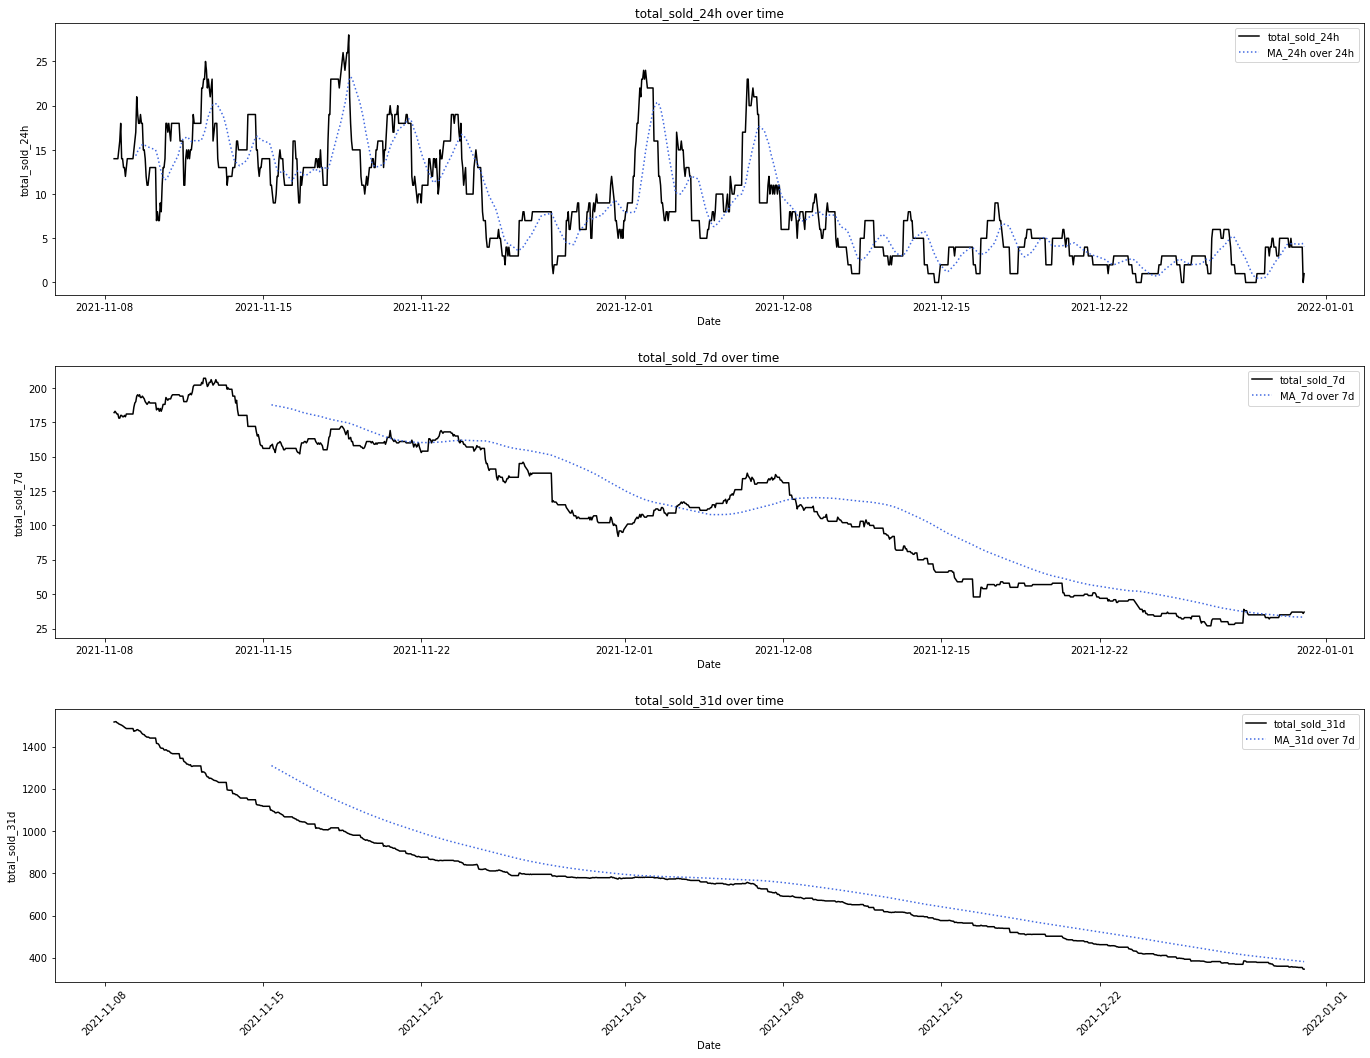

In [15]:
plt.clf()
fig, ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(20,15)
fig.tight_layout(pad=5.0)
ax[0].plot(df_ts_sold_mixed_ff['date_time'], df_ts_sold_mixed_ff['total_sold_24h'], color='black', label='total_sold_24h')
ax[0].plot(df_ts_sold_mixed_ff['date_time'], df_ts_sold_mixed_ff['SOLD_MA_24h'], linestyle=':', color='royalblue', label='MA_24h over 24h')
ax[0].legend()
ax[0].set_title("total_sold_24h over time")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("total_sold_24h")

ax[1].plot(df_ts_sold_mixed_ff['date_time'], df_ts_sold_mixed_ff['total_sold_7d'], color='black', label='total_sold_7d')
ax[1].plot(df_ts_sold_mixed_ff['date_time'], df_ts_sold_mixed_ff['SOLD_MA_7D'], linestyle=':', color='royalblue', label='MA_7d over 7d')
ax[1].legend()
ax[1].set_title("total_sold_7d over time")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("total_sold_7d")

ax[2].plot(df_ts_sold_mixed_ff['date_time'], df_ts_sold_mixed_ff['total_sold_31d'], color='black', label='total_sold_31d')
ax[2].plot(df_ts_sold_mixed_ff['date_time'], df_ts_sold_mixed_ff['SOLD_MA_31D'], linestyle=':', color='royalblue', label='MA_31d over 7d')
ax[2].legend() 
ax[2].set_title("total_sold_31d over time")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("total_sold_31d")


# Plot settings
plt.xticks(rotation=45)
#ax[0].xticks(rotation=45)
# fig(figsize=(20,20))


plt.show()